## Make Fake Data

We produce a catalog of clusters only for controled experiments.

In [4]:
## gal
## R, zoffset 
## member, field

## cat
## M200, z

In [5]:
import numpy as np
from astropy.table import Table, vstack, join

import seaborn as sns
sns.set_style('darkgrid')

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

import matplotlib 
import matplotlib.pyplot as plt

from scipy.special import erf

In [6]:
sns.set_context('notebook')

In [7]:
def plot_scatter_hist(x,y,xlabel=r'$z$',ylabel=r'$\log(M_{200,c})\,\,[M_{\odot}\; h^{-1}]$',save='./img/bla.png'):
    fig = plt.figure(figsize=(10,8))

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.01
    scale = 70
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.125]
    rect_histy = [left + width + spacing, bottom, 0.125, height]

    scatter_axes = plt.axes(rect_scatter)
    scatter_axes.tick_params(direction='in', top=True, right=True)
    x_hist_axes = plt.axes(rect_histx,sharex=scatter_axes)
    x_hist_axes.tick_params(direction='in')
    y_hist_axes = plt.axes(rect_histy,sharey=scatter_axes)
    y_hist_axes.tick_params(direction='in')
    
    xmax = np.nanmax(x)
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    
    binx = np.linspace(0.1, xmax, num=11)
    biny = np.linspace(ymin, ymax, num=11)  # 1500/100.

    pal = sns.dark_palette("#3498db", as_cmap=True)
    # sns.kdeplot(x, y, ax=scatter_axes, cmap=pal, zorder=3)  # n_levels=10

    scatter_axes.set_xlabel(xlabel, fontsize=25)
    scatter_axes.set_ylabel(ylabel, fontsize=25)

    scatter_axes.scatter(x, y, s=scale, marker='o', alpha=0.6, zorder=0)
#     scatter_axes.axhline(np.mean(y),linestyle='--',color='b')

    x_hist_axes.hist(x, bins=binx, density=False, alpha=0.6)
    y_hist_axes.hist(y, bins=biny, density=False, orientation='horizontal', alpha=0.6)
#     y_hist_axes.axhline(np.mean(y),linestyle='--', color='b')
    
    x_hist_axes.set_yticklabels([])
    y_hist_axes.set_xticklabels([])

    if ymax<0:
        ymin,ymax=13.5,15.3

        scatter_axes.set_ylim(ymin, ymax)
        y_hist_axes.set_ylim(ymin, ymax)

    scatter_axes.xaxis.set_tick_params(labelsize=15)
    scatter_axes.yaxis.set_tick_params(labelsize=15)
    x_hist_axes.xaxis.set_tick_params(labelsize=0.05, labelcolor='white')
    y_hist_axes.yaxis.set_tick_params(labelsize=0.05, labelcolor='white')

    fig.subplots_adjust(hspace=.01, wspace=0.01)


In [8]:
## compute r200
def convertM200toR200(M200,z):
    ## M200 in solar masses
    ## R200 in Mpc
    rho = rhoc(z)
    R200 = np.power( M200/(200*4*np.pi*rho/3) , 1/3.  )
    return R200


In [9]:
## compute n200

#Mass-richness relation functions (see Tinker et al 2011)
def ncen(M,log_Mmin,sigma):
    #takes logM_min and logSigma_logM from paper. returns Ncentral from paper
    sigma=10**sigma
    return (1./2.)*(1+erf((np.log10(M)-log_Mmin)/sigma))

def ntot(M,Msat,log_Mmin,sigma,alpha_sat,Mcut):
    #takes logMmin, logSigma_logM, logMsat, logMcut from paper. Returns Ntotal=Ncentral+Nsatellite from paper
    Msat=10**Msat
    Mcut=10**Mcut
    return ncen(M,log_Mmin,sigma)*(1+(((M/Msat)**alpha_sat)*np.exp(-Mcut/M)))

#Msat redshift dependence 
def logMsat(z,M0=12.33,a=-0.27):
    return M0 + a*z

#alpha_sat redshift dependence - currently used for redshift varying HOD model
def alpha_sat(z,alpha0=1.0,a=0.0,z0=0.5):
    if z> z0: 
        return alpha0 + a*(z-z0) #+ (alpha0+a*z)
    else: 
        return alpha0


In [10]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.283)
Msol = 1.98847e33
Mpc2cm = 3.086e+24
rad2deg= 180/np.pi
h=0.7

#--- Critical universe density
def rhoc(z):
    try:
        rho_c = float(cosmo.critical_density(z)/(u.g/u.cm**3)) # in g/cm**3
    except:
        rho_c = [float(cosmo.critical_density(zi)/(u.g/u.cm**3)) for zi in z]
        rho_c = np.array(rho_c)
    
    rho_c = rho_c*(Mpc2cm**3)/Msol # in Msol/Mpc**3
    return rho_c

In [11]:
class fake_cluster_field:
    def generate_cluster_catalog(self,nclusters,log_mass_min=13.,log_mass_max=15.,z_min=0.1,z_max=0.6):
        self.ncls = nclusters
        
        ## grid in z,m200 space
        nbins     = int(np.sqrt(self.ncls))
        mvec = np.logspace(log_mass_min,log_mass_max,nbins)
        zvec = np.linspace(z_min,z_max,nbins)
        mm, zz = np.meshgrid(mvec,zvec)
        m200 = mm.flatten()
        zcls = zz.flatten()
        
        ## other variables
        log_m200 = np.log10(m200) 
        r200 = convertM200toR200(m200,zcls)
        
        ## estimate N200 (HOD model)
        params = [11.59,12.94,1.01,12.48,-0.69]#parameters for mass conversion - see table 4 in Tinker paper
        Mmin  = params[0]
        Msat  = params[1]
        alpha = params[2]
        Mcut  = params[3]
        sigma = params[4]

        print('adding noise to m200: %.2f %%'%(10**sigma))
        m200_noise = m200*(1 + np.random.normal(scale=10**sigma,size=m200.size))
        n200  = ntot(m200_noise,Msat,Mmin,sigma,alpha,Mcut).astype(int)
        
        ## saving table
        indices = np.arange(zcls.size)
        cat = Table(data=[indices,zcls,m200,r200,n200],names=['cid','redshift','M200','R200','N200'])
        self.cat = cat
        
        

In [12]:
fake = fake_cluster_field()
fake.generate_cluster_catalog(1000,log_mass_min=13.5,z_max=.7)

adding noise to m200: 0.20 %


In [13]:
fake.cat

cid,redshift,M200,R200,N200
int64,float64,float64,float64,int64
0,0.1,31622776601683.793,0.6330627140111492,5
1,0.1,35481338923357.6,0.6578295858554106,5
2,0.1,39810717055349.695,0.683565394785009,4
3,0.1,44668359215096.35,0.7103080478509958,5
4,0.1,50118723362727.15,0.7380969351155877,7
5,0.1,56234132519034.91,0.7669729876709873,7
6,0.1,63095734448019.43,0.7969787379280197,7
7,0.1,70794578438413.73,0.8281583822634085,8
8,0.1,79432823472428.22,0.8605578461179603,7


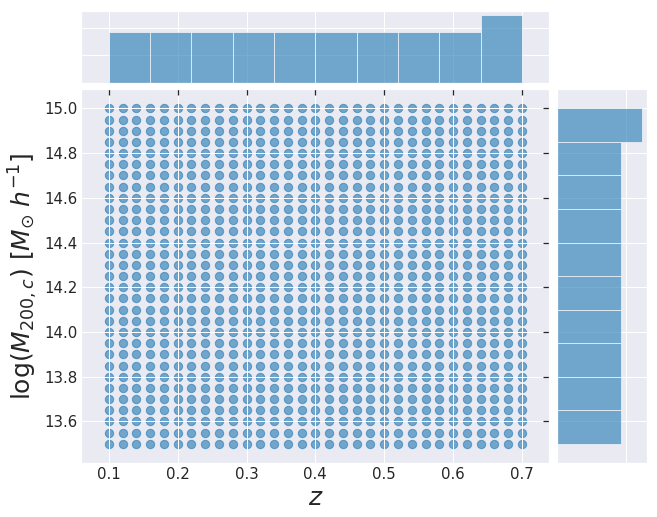

In [14]:
plot_scatter_hist(fake.cat['redshift'],np.log10(fake.cat['M200']))

Text(0.5,0,'M_200')

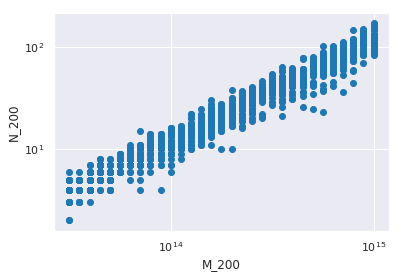

In [15]:
plt.scatter(fake.cat['M200'],fake.cat['N200'])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N_200')
plt.xlabel('M_200')

In [16]:
def profileNFW(R,R200,c=3):
    #Radial NFW profile implementation. Takes array of radii, value of R200,
    #and NFW concentration parameter (set to 3 by default)
    if R200>0:
        Rs=float(R200)/c
        r=R/Rs
        r=np.where(np.logical_or(r<=1e-5,r==1.),r+0.001,r)
        pre=1./((r**2)-1)
        arctan_coeff=2./(np.sqrt(np.abs(r**2-1)))
        arctan_arg=np.sqrt(np.abs((r-1)/(r+1)))
        sigma=np.where(r>1,pre*(1-arctan_coeff*np.arctan(arctan_arg)),pre*(1-arctan_coeff*np.arctanh(arctan_arg)))
        
        return sigma*2*Rs
    
    else:
        bogusval=-99.*np.ones_like(R)
        return bogusval

def radial_pdf(radii,R200,c=3.5,rc=0.2):
    radii   = np.where(radii<rc/2.,rc/2.,radii)
    density = profileNFW(radii,R200,c=c) ## without norm
    density = np.where(radii<rc,np.mean(density[radii<rc]), density)
    return density

In [17]:
np.random.seed(42)
def generate_galaxy_radii_distribution(r200,n200):
    """It generates a list of member galaxies with Pmem distribution
    input: ra,dec,radius[arcmin]
    """
    rad   =r200      ##Mpc
    R200  =r200
    
    radius_rnd = np.random.uniform(0.,rad,10000)
    
    pmem_rnd = radial_pdf(radius_rnd,r200)
    pmem_rnd = np.where(pmem_rnd<0.,0.,pmem_rnd)
    pmem_rnd_norm = pmem_rnd/sum(pmem_rnd)
    
    ## Draw the NFW model distribution
    idx_rnd = np.arange(len(radius_rnd))
    idx = np.random.choice(idx_rnd, size=n200, p=pmem_rnd_norm)
    return radius_rnd[idx]

In [20]:
from scipy import integrate

def compute_pdfz(zoffset,membzerr,sigma,zcls,npoints=1000,correction=True):
    ''' Computes the probability of a galaxy be in the cluster
        for an interval with width n*windows. 
        Assumes that the galaxy has a gaussian redshift PDF.

        npoints=1000 # it's accurate in 2%% level
    '''  
    zmin, zmax = zcls-5*sigma, zcls+5*sigma
    #zmin = check_boundaries(zmin,zcls)
    
    ## photo-z floor
    membzerr= np.where(membzerr<0.005,0.005,membzerr)

    ## multi dymensional arrays
    z       = np.linspace(zmin,zmax,npoints)
    #zz, yy  = np.meshgrid(z,np.array(zoffset)*(1+zcls)) ## dz = z-z_cls; zoffset = (z-z_cls)/(1+z_cls) 
    zz, yy  = np.meshgrid(z,np.array(zoffset)) ## dz = z-z_cls; zoffset = (z-z_cls)/(1+z_cls) 
    zz, yy2 = np.meshgrid(z,np.array(membzerr))
    
    ## assuming sigma_gal=sigma_cls:  the conv(pdf_gal,pdf_cls)-> N(mean=zp-zc,sigma=sigma0*np.sqrt(2))
    ## yy2 = np.sqrt(2)*yy2
    
    if correction:
        pdfz = gaussian_corrected(zz,yy,yy2/(1+zcls))
        pdfz_max = gaussian_corrected(z,np.zeros_like(z),sigma/(1+zcls))
            
    else:
        pdfz = gaussian(zz,yy,np.sqrt(yy2**2+sigma**2))
        pdfz_max = gaussian(z,np.zeros_like(z),sigma)
    
    w,  = np.where( np.abs(z-zcls) <= 2.*sigma) ## integrate in 1.5*sigma
    p0 = integrate.trapz(pdfz[:,w],x=zz[:,w])
    
    pmax = integrate.trapz(pdfz_max[w],x=z[w])
    pz   = p0#/pmax

    ## get out with galaxies outside 3 sigma
    pz = np.where(np.abs(zoffset-zcls) >= 2.*sigma, 0., pz)

    return pz

def check_boundaries(zmin,zcls):
    zoff_min = zcls+zmin*(1+zcls)
    if zoff_min<0:
        return zmin-zoff_min
    else:
        return zmin

def gaussian(x,mu,sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def gaussian_corrected(x,mu,sigma):
    sigma_cor = sigma*(1+x)
    return np.exp(-(x-mu)**2/(2*sigma_cor**2))/(sigma_cor*np.sqrt(2*np.pi))


In [21]:
def generate_galaxy_photoz_distribution(zcls,Ngals,zwindow=0.03,delta_z=0.001):
    #np.random.seed(3)
    ztrue= zcls+np.random.normal(scale=delta_z,size=Ngals)*(1+zcls)
    zerr = zwindow*np.ones_like(ztrue)*(1+ztrue)
    
    znoise= ztrue+np.random.normal(scale=zwindow,size=Ngals)*(1+ztrue)
    znoise= np.where(znoise<0.,0.,znoise) # there is no negative redshift

    ## compute zoffset
    zoffset     = (znoise-zcls)/(1+zcls)
    pz0 = compute_pdfz(znoise,zerr,zwindow*(1+zcls),zcls,correction=True)
    return ztrue, znoise, zerr, zoffset, pz0

In [22]:
zcls   = np.array(fake.cat['redshift'][:])
ngalst = np.array(fake.cat['N200'][:]).astype(int)
m200   = np.array(fake.cat['M200'][:])


In [23]:
ngals = []
for i in range(len(zcls)):
    out = generate_galaxy_photoz_distribution(zcls[i],ngalst[i],zwindow=0.03,delta_z=0.001)
    pz0 = out[-1]
    ngals.append(np.sum(pz0))

In [24]:
def mad(data, axis=None):
    return np.median(np.abs(data - np.median(data)))

def get_sigmaNMAD(x):
    sigmaNMAD = 1.48*mad(x)
    return sigmaNMAD


In [25]:
residual = ngals/ngalst
log_residual = np.log10(residual)

mean   = np.median(residual)
sigma  = get_sigmaNMAD(residual)

In [26]:
1-np.array([0.136+2.1/100+0.1/100,2.1/100+0.1/100,0.1/100])

array([0.842, 0.978, 0.999])

In [27]:
print('mean: %.3f'%mean)
print('scatter: %.3f'%(sigma))

mean: 0.833
scatter: 0.044


In [28]:
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    means = (xedges[1:]+xedges[:-1])/2.
    indices = []
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

In [187]:
nbins = np.logspace( np.log10(np.min(ngalst)), np.log10(np.max(ngalst)),11)
                    
keys,nmed = get_bins(ngalst,nbins)
ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr = np.array([np.std(residual[idx]) for idx in keys])

Text(0,0.5,'sum(pz0)/N_true')

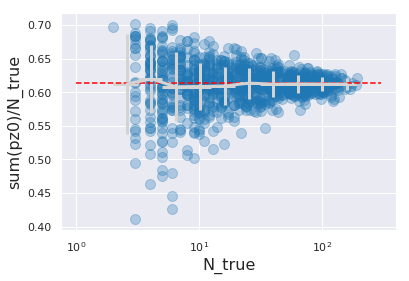

In [188]:
#plt.plot([1,300],[1,1],'k--')
plt.plot([1,300],[mean,mean],'r--')
plt.scatter(ngalst,residual,s=100,alpha=0.3)
plt.errorbar(nmed,ymed,xerr=np.diff(nbins)/2.,yerr=yerr,color='lightgray',lw=3)
plt.xscale('log')
#plt.yscale('log')
# plt.ylim(0.85,1.01)
plt.xlabel('N_true',fontsize=16)
plt.ylabel('sum(pz0)/N_true',fontsize=16)

In [189]:
#plt.scatter(nmed,ymed)

In [190]:
zbins = np.linspace(0.1,1.,21)
keys,zmed = get_bins(zcls,zbins)
ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr = np.array([np.std(residual[idx]) for idx in keys])

Text(0.5,0,'redshift')

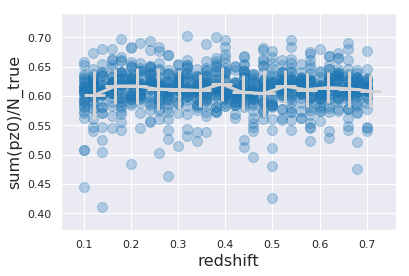

In [191]:
plt.scatter(zcls,residual,s=100,alpha=0.3)
plt.errorbar(zmed,ymed,xerr=np.diff(zbins)/2.,yerr=yerr,color='lightgray',lw=3)
plt.ylabel('sum(pz0)/N_true',fontsize=16)
plt.xlabel('redshift',fontsize=16)
# plt.ylim(0.9,1.01)

In [192]:
from scipy import stats
stats.spearmanr(zcls,residual)

SpearmanrResult(correlation=-0.0028232100843102186, pvalue=0.9303489755919241)

## Convoluted Model

In [217]:
def compute_pdfz(zoffset,membzerr,sigma,zcls,npoints=1000,correction=True):
    ''' Computes the probability of a galaxy be in the cluster
        for an interval with width n*windows. 
        Assumes that the galaxy has a gaussian redshift PDF.

        npoints=1000 # it's accurate in 2%% level
    '''  
    zmin, zmax = -5*sigma, 5*sigma
    #zmin = check_boundaries(zmin,zcls)
    
    ## photo-z floor
    membzerr= np.where(membzerr<0.005,0.005,membzerr)

    ## multi dymensional arrays
    z       = np.linspace(zmin,zmax,npoints)
    zz, yy  = np.meshgrid(z,np.array(zoffset)*(1+zcls)) ## dz = z-z_cls; zoffset = (z-z_cls)/(1+z_cls) 
    zz, yy2 = np.meshgrid(z,np.array(membzerr))
    
    ## assuming sigma_gal=sigma_cls:  the conv(pdf_gal,pdf_cls)-> N(mean=zp-zc,sigma=sigma0*np.sqrt(2))
    ## yy2 = np.sqrt(2)*yy2
    weight=3*sigma
    if correction:
        pdfz = gaussian_corrected(zz,yy,np.sqrt(yy2**2+sigma**2))#/weight
        pdfz_max = gaussian_corrected(z,np.zeros_like(z),np.sqrt(2)*sigma)#/weight
            
    else:
        pdfz = gaussian(zz,yy,yy2)
        pdfz_max = gaussian(z,np.zeros_like(z),sigma)
    
    w,  = np.where( np.abs(z) <= 1.5*sigma) ## integrate in 1.5*sigma
    p0 = integrate.trapz(pdfz[:,w],x=zz[:,w])
    
    pmax = integrate.trapz(pdfz_max[w],x=z[w])
    pz   = p0#/pmax

    ## get out with galaxies outside 3 sigma
    pz = np.where(np.abs(zoffset) >= 3.*sigma, 0., pz)

    return pz

In [218]:
i= 20
sigma = 0.03
npoints= 5000

In [219]:
def generate_galaxy_photoz_distribution(zcls,Ngals,zwindow=0.03,delta_z=0.001):
    #np.random.seed(3)
    ztrue= zcls+np.random.normal(scale=delta_z,size=Ngals)*(1+zcls)
    zerr = zwindow*np.ones_like(ztrue)*(1+ztrue)
    
    znoise= ztrue+np.random.normal(scale=zwindow,size=Ngals)*(1+ztrue)
    znoise= np.where(znoise<0.,0.,znoise) # there is no negative redshift

    ## compute zoffset
    zoffset     = (znoise-zcls)/(1+zcls)
    pz0 = compute_pdfz(zoffset,zerr,zwindow*(1+zcls),zcls,correction=True)
    return ztrue, znoise, zerr, zoffset, pz0

ztrue, znoise, zerr, zoffset, pz0 = generate_galaxy_photoz_distribution(
                                    zcls[i],ngalst[i],zwindow=sigma,delta_z=0.001)

In [158]:
membzerr = zerr

In [159]:
zmin, zmax = -5*sigma, 5*sigma
#zmin = check_boundaries(zmin,zcls)

## photo-z floor
membzerr= np.where(membzerr<0.005,0.005,membzerr)

## multi dymensional arrays
z       = np.linspace(zmin,zmax,npoints)
zz, yy  = np.meshgrid(z,0.1+np.array(zoffset)*(1+zcls[i])) ## dz = z-z_cls; zoffset = (z-z_cls)/(1+z_cls) 
zz, yy2 = np.meshgrid(z,2*np.array(membzerr))

step = np.diff(z)[0]

In [160]:
pdfz = gaussian_corrected(zz,yy,yy2)
pdfc = gaussian_corrected(zz,np.zeros_like(yy),sigma)
conv = np.convolve(pdfz[5],pdfc[5],mode='same')*step.copy()
conv_theoretical = gaussian(zz,yy,np.sqrt(yy2**2+sigma**2))

In [161]:
ngals = []
for i in range(len(zcls)):
    out = generate_galaxy_photoz_distribution(zcls[i],ngalst[i],zwindow=0.01,delta_z=0.001)
    pz0 = out[-1]
    ngals.append(np.sum(pz0))

In [162]:
def mad(data, axis=None):
    return np.median(np.abs(data - np.median(data)))

def get_sigmaNMAD(x):
    sigmaNMAD = 1.48*mad(x)
    return sigmaNMAD


In [163]:
w, = np.where(ngalst>10.)
residual = ngals/ngalst
log_residual = np.log10(residual)

mean   = np.median(residual[w])
sigma  = get_sigmaNMAD(residual[w])

In [164]:
1-np.array([0.136+2.1/100+0.1/100,2.1/100+0.1/100,0.1/100])

array([0.842, 0.978, 0.999])

In [165]:
print('mean: %.3f'%mean)
print('scatter: %.3f'%(sigma))

mean: 0.613
scatter: 0.019


In [166]:
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    means = (xedges[1:]+xedges[:-1])/2.
    indices = []
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

In [167]:
nbins = np.logspace( np.log10(np.min(ngalst)), np.log10(np.max(ngalst)),11)
                    
keys,nmed = get_bins(ngalst,nbins)
ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr = np.array([np.std(residual[idx]) for idx in keys])

Text(0,0.5,'sum(pz0)/N_true')

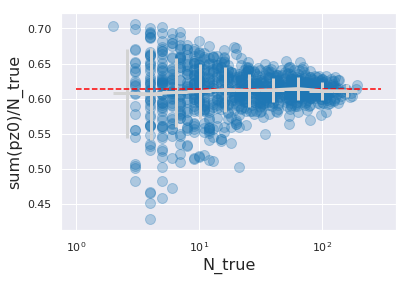

In [169]:
#plt.plot([1,300],[1,1],'k--')
plt.plot([1,300],[mean,mean],'r--')
plt.scatter(ngalst,residual,s=100,alpha=0.3)
plt.errorbar(nmed,ymed,xerr=np.diff(nbins)/2.,yerr=yerr,color='lightgray',lw=3)
plt.xscale('log')
#plt.yscale('log')
# plt.ylim(0.85,1.01)
plt.xlabel('N_true',fontsize=16)
plt.ylabel('sum(pz0)/N_true',fontsize=16)
#plt.ylim(0.60,0.85)

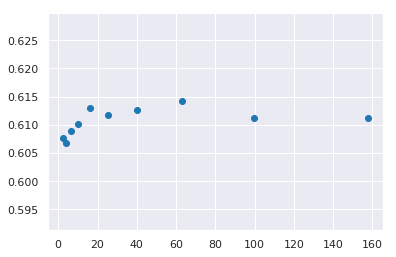

In [170]:
plt.scatter(nmed,ymed)

In [173]:
zbins = np.linspace(0.1,1.,21)
keys,zmed = get_bins(zcls,zbins)
ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr = np.array([np.std(residual[idx]) for idx in keys])

Text(0.5,0,'redshift')

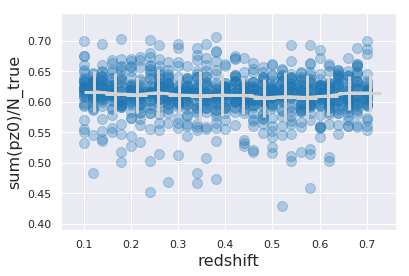

In [174]:
#plt.plot([1,300],[1,1],'k--')
#plt.plot([1,300],[mean,mean],'r--')
plt.scatter(zcls,residual,s=100,alpha=0.3)
plt.errorbar(zmed,ymed,xerr=np.diff(zbins)/2.,yerr=yerr,color='lightgray',lw=3)

#plt.ylim(mean-3*sigma,mean+3*sigma)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('sum(pz0)/N_true',fontsize=16)
plt.xlabel('redshift',fontsize=16)
# plt.ylim(0.9,1.01)

In [175]:
from scipy import stats
stats.spearmanr(zcls,residual)

SpearmanrResult(correlation=-0.06561908524836896, pvalue=0.04197818795675379)

## Add Magnitude Depedence

In [185]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")
from main import copacabana

In [93]:
cfg='/home/s1/jesteves/git/ccopa/config_files/config_buzzard_v2.yaml'
dataset='buzzard_v2'

copa = copacabana(cfg,dataset=dataset)

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_golden_00032.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_golden_00033.hdf5
outdir: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/
tile path: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles


In [94]:
run_name = 'dnf-r200'
cat = copa.load_copa_out('cluster',run_name)
gal = copa.load_copa_out('members',run_name)

Matching Copa output with main and BMA
Matching Copa output with main and BMA


In [95]:
## PDF(m)

true = gal['redshift']>.0
zgal = gal['redshift'][true]
magi = gal['mag'][:,2][true]
dmag = gal['dmag'][true]

ztrue = gal['z_true'][true]
zp    = gal['z'][true]
dz    = (ztrue - zp)/(1+ztrue)

In [96]:
def group_by(x,keys):
    return [x[idx] for idx in keys]
    
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    indices = []
    means = (xedges[1:]+xedges[:-1])/2.
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

def fractional_error_percentile(var):
    p16 = np.nanpercentile(var, 16)
    p84 = np.nanpercentile(var, 84)
    score = 0.5*(p84-p16)
    return score

def mad(data, axis=None):
    return np.median(np.abs(data - np.median(data)))

def get_sigmaNMAD(var):
    sigmaNMAD = 1.48*mad(var)
    return sigmaNMAD

def get_outlier_frac(var):
    sigmaNMAD = 1.48*mad(var)
    bias      = np.nanmedian(var)
    out       = np.where(np.abs((var-bias)>=3.*sigmaNMAD))[0]
    frac      = 1.*out.size/var.size
    return frac

In [97]:
mbins = np.linspace(15.853,23.02,24)

w, = np.where(zgal>0.)

keys,mb  = get_bins(magi[w],mbins)
dz_bins_g= group_by(dz[w],keys)

scatter_b= np.array([get_sigmaNMAD(db) for db in dz_bins_g])
bias_b   = np.array([np.nanmedian(db) for db in dz_bins_g])

Text(0.5,0,'mag_i')

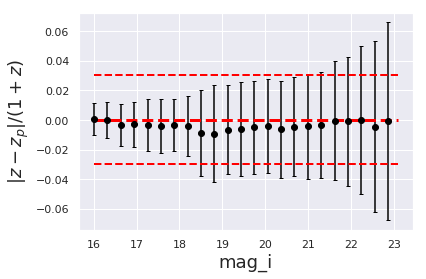

In [98]:
plt.errorbar(mb,bias_b,color='k',fmt='o',capsize=2,yerr=scatter_b)
plt.plot([16.,23.1],[0.,0.],'r--',lw=3)
plt.plot([16.,23.1],[-.03,-0.03],'r--',lw=2)
plt.plot([16.,23.1],[+.03,+0.03],'r--',lw=2)
plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('mag_i',fontsize=18)


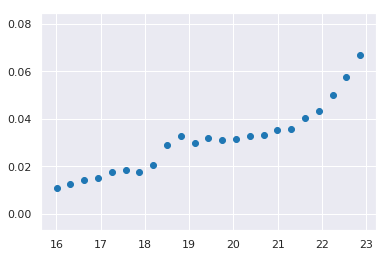

In [624]:
## interpolate this
plt.scatter(mb,scatter_b)

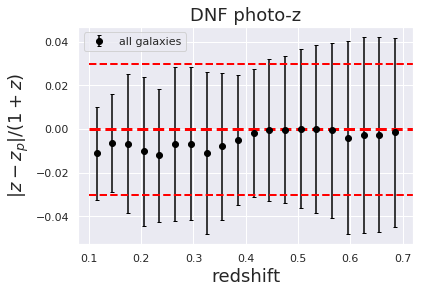

In [625]:
zbins = np.linspace(0.1,0.7,21)

mask = gal['True']
keys,zb  = get_bins(zgal[true],zbins)
dz_bins_g= group_by(dz[true],keys)

scatter_zb= np.array([get_sigmaNMAD(db) for db in dz_bins_g])
bias_zb   = np.array([np.median(db) for db in dz_bins_g])
#of_bt     = np.array([get_outlier_frac(db) for db in dz_bins_g]) 

plt.errorbar(zb,bias_zb,color='k',fmt='o',capsize=2,yerr=scatter_zb,label='all galaxies')
#plt.errorbar(zb+0.005,bias_bt,color='r',fmt='o',capsize=2,yerr=scatter_bt,label='true members')

plt.plot([0.1,1.],[0.,0.],'r--',lw=3)
plt.plot([0.1,1.],[-.03,-0.03],'r--',lw=2)
plt.plot([0.1,1.],[+.03,+0.03],'r--',lw=2)

plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('redshift',fontsize=18)
plt.title('DNF photo-z',fontsize=18)
plt.xlim(0.08,0.72)
plt.legend()

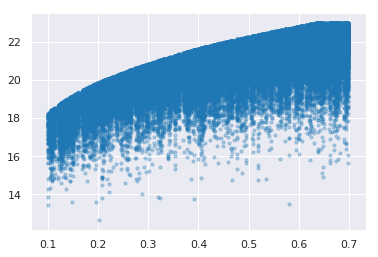

In [626]:
plt.scatter(zgal,magi,s=10,alpha=0.3)

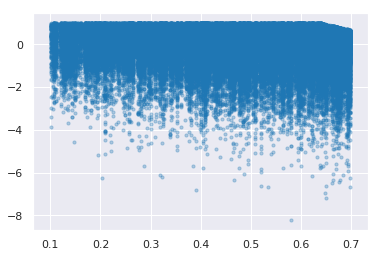

In [627]:
plt.scatter(zgal,dmag,s=10,alpha=0.3)

In [628]:
# def schechter_function(m,ms,alpha=0.):
#     c0 = 10**(-0.4*(m-ms))
#     c1 = c0*np.exp(c0)
#     c2 = 10**(alpha+1)*c1
#     norm = np.sum(c2)
#     return c2/norm

Text(0.5,0,'$m_i - m_{i}^{\\star}$')

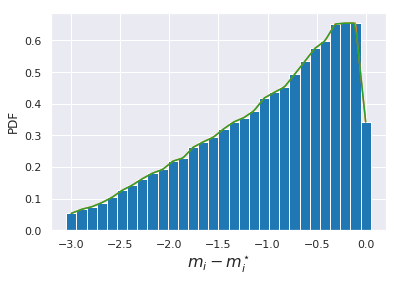

In [629]:
w, = np.where(zgal<0.8)

mbins   = np.linspace(-3.05,0.05,31)
mmed    = 0.5*(mbins[1:]+mbins[:-1])
ng      = np.histogram(dmag[w]-1,bins=mbins,density=True)[0]

mag_vec = np.linspace(-3.,0.,100)
pdf_vec = np.interp(mag_vec,mmed,ng)

_ = plt.hist(dmag[w]-1,density=True,bins=mbins)
plt.plot(mmed,ng)
plt.plot(mag_vec,pdf_vec)
plt.ylabel('PDF')
plt.xlabel('$m_i - m_{i}^{\star}$',fontsize=16)

In [630]:
zbins    = np.arange(0.1,0.7+0.05,0.05)
keys,zmed = get_bins(zgal,zbins)

mimax = np.array([np.max(magi[idx]) for idx in keys])

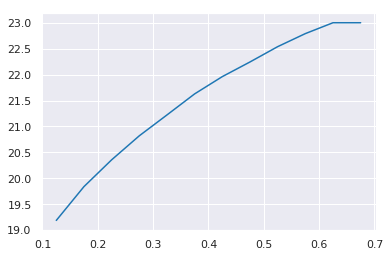

In [631]:
plt.plot(zmed,mimax)

In [632]:
import scipy

pdf_mag   = scipy.interpolate.interp1d(mmed,ng,fill_value='extrapolate')
mag_i_max = scipy.interpolate.interp1d(zmed,mimax,fill_value='extrapolate')
sigma_mag = scipy.interpolate.interp1d(mb,scatter_b,fill_value='extrapolate')

In [633]:
pdf_mag(-3.)

array(0.05287872)

In [634]:
def generate_mag(Ngals,zcls,lims=(-3.,0.)):
    mag_rnd = np.linspace(lims[0],lims[1],10000)
    idx_rnd = np.arange(len(mag_rnd))
    prob    = pdf_mag(mag_rnd)
    
    idx = np.random.choice(idx_rnd, size=Ngals, p=prob/np.sum(prob))
    
    dmag = mag_rnd[idx]
    magi = mag_i_max(zcls) + dmag
    return dmag, magi

In [198]:
def generate_table(data,columns):
    res = Table()
    for col,arr in zip(columns,data):
        res[col] = arr
    return res

In [199]:
def generate_galaxy_photoz_distribution_mag(zcls,Ngals,zwindow=0.03,delta_z=0.001):
    #np.random.seed(3)
    ztrue= zcls+np.random.normal(scale=delta_z,size=Ngals)*(1+zcls)
    zerr = zwindow*(1+ztrue)
    
    znoise= ztrue+np.random.normal(scale=zwindow,size=Ngals)*(1+ztrue)
    znoise= np.where(znoise<0.,0.,znoise) # there is no negative redshift

    ## compute zoffset
    zoffset     = (znoise-zcls)/(1+zcls)
    pz0 = compute_pdfz(zoffset,zerr,np.median(zwindow)*(1+zcls),zcls,correction=True)
    return ztrue, znoise, zerr, zoffset, pz0

In [200]:
data = []
ngals,ngalsm= [],[]
for i in range(len(zcls)):
    dmag, magi = generate_mag(ngalst[i],zcls[i])
    ztrue, znoise, zerr, zoffset, pz0m = generate_galaxy_photoz_distribution_mag(zcls[i],ngalst[i],
                                                                                zwindow=sigma_mag(magi),delta_z=0.001)
    ti = generate_table([ztrue,znoise,zerr,zoffset,pz0m, magi, dmag],['z_true','z','zerr','zoffset','pz0', 'mag','dmag'])
    ti['CID'] = i
    ti['redshift'] = zcls[i]
    
    out = generate_galaxy_photoz_distribution(zcls[i],ngalst[i],zwindow=0.03,delta_z=0.001)
    pz0 = out[-1]
    ngals.append(np.sum(pz0))
    
    data.append(ti)
    ngalsm.append(np.sum(pz0m))

NameError: name 'generate_mag' is not defined

In [638]:
galf = vstack(data)

In [639]:
galf

z_true,z,zerr,zoffset,pz0,mag,dmag,CID,redshift
float64,float64,float64,float64,float64,float64,float64,int64,float64
0.10072839851434977,0.10835907757247243,0.019936343330010875,0.007599161429520384,1.1074452218595567,17.623748609048985,-1.2379237923792379,0,0.1
0.10068517377313245,0.12487499326296114,0.016881152094469686,0.022613630239055577,0.8806817910833098,16.97958419260734,-1.882088208820882,0,0.1
0.09897286161294207,0.09308275888066027,0.019468932168654574,-0.0062884010175815784,1.1398749812920197,17.83106934112219,-1.0306030603060305,0,0.1
0.09950791887272059,0.07629084214717183,0.03317635360480045,-0.02155377986620743,0.7928293351414958,18.60034626881496,-0.2613261326132612,1,0.1
0.10038778413757476,0.10810365754590621,0.03584512182651272,0.007366961405369281,0.8548262021852606,18.823268561044184,-0.0384038403840381,1,0.1
0.10037786812621709,0.10644284744150315,0.01574075408527425,0.005857134037730128,1.2097332704636639,16.68855508969705,-2.173117311731173,1,0.1
0.09953640743461348,0.10276789057950886,0.016169785182142776,0.002516264163189866,1.2252698512323046,16.82986922111019,-2.0318031803180316,1,0.1
0.1003799522847429,0.10741002327912003,0.02002850253613,0.0067363847992000184,1.1251821615578987,17.57694392858094,-1.2847284728472845,1,0.1
0.1006981392490676,0.07754334452980494,0.020000000750950167,-0.02041514133654097,0.9460513953859492,17.536739908178898,-1.3249324932493247,2,0.1


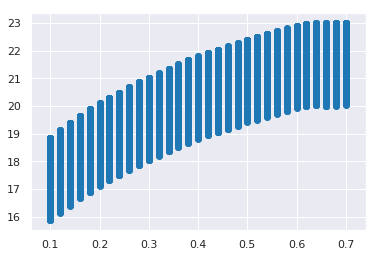

In [640]:
plt.scatter(galf['redshift'],galf['mag'])

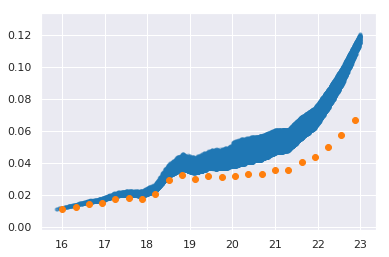

In [641]:
plt.scatter(galf['mag'],galf['zerr'],s=10,alpha=0.3)
plt.scatter(mb,sigma_mag(mb))
#plt.scatter(gal['mag'][:,2],gal['zerr'],s=10,alpha=0.3)

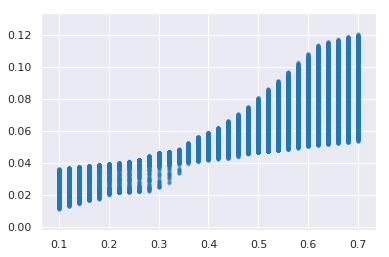

In [642]:
plt.scatter(galf['redshift'],galf['zerr'],s=10,alpha=0.3)

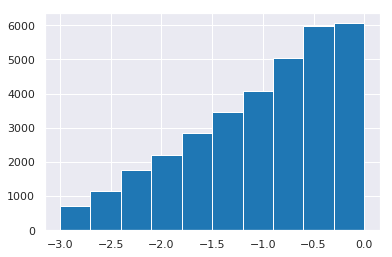

In [643]:
_ = plt.hist(galf['dmag'])

In [644]:
residualm = np.array(ngalsm)/ngalst
residual = np.array(ngals)/ngalst
#log_residual = np.log10(residual)

mean   = np.median(residualm)
sigma  = get_sigmaNMAD(residualm)

In [645]:
1-np.array([0.136+2.1/100+0.1/100,2.1/100+0.1/100,0.1/100])

array([0.842, 0.978, 0.999])

In [646]:
print('mean: %.3f'%mean)
print('scatter: %.3f'%(sigma))

mean: 1.002
scatter: 0.049


In [647]:
nbins = np.logspace( np.log10(np.min(ngalst)), np.log10(np.max(ngalst)),11)
                    
keys,_ = get_bins(ngalst,nbins)
ymedm = np.array([np.mean(residualm[idx]) for idx in keys])
yerrm  = np.array([np.std(residualm[idx]) for idx in keys])

ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr  = np.array([np.std(residual[idx]) for idx in keys])

Text(0,0.5,'sum(pz0)/N_true')

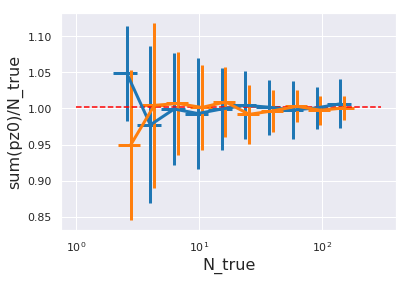

In [648]:
#plt.plot([1,300],[1,1],'k--')
plt.plot([1,300],[mean,mean],'r--')
#plt.scatter(ngalst,residual,s=100,alpha=0.3)
plt.errorbar(nmed,ymedm,xerr=np.diff(nbins)/2.,yerr=yerrm,lw=3,label='mag model')
plt.errorbar(nmed*(1.075),ymed,xerr=np.diff(nbins)/2.,yerr=yerr,lw=3)
plt.xscale('log')
#plt.yscale('log')
# plt.ylim(0.85,1.01)
plt.xlabel('N_true',fontsize=16)
plt.ylabel('sum(pz0)/N_true',fontsize=16)

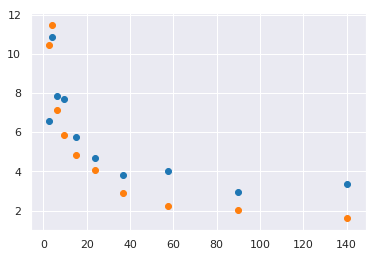

In [649]:
plt.scatter(nmed,yerrm*100)
plt.scatter(nmed,yerr*100)

In [650]:
zbins = np.linspace(0.1,1.,21)
keys,zmed = get_bins(zcls,zbins)

ymedm = np.array([np.mean(residualm[idx]) for idx in keys])
yerrm = np.array([np.std(residualm[idx]) for idx in keys])

ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr = np.array([np.std(residual[idx]) for idx in keys])

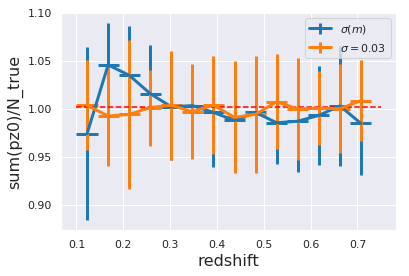

In [651]:
#plt.plot([1,300],[1,1],'k--')
plt.plot([0.1,0.75],[mean,mean],'r--')
#plt.scatter(zcls,residualm,s=100,alpha=0.3)
plt.errorbar(zmed,ymedm,xerr=np.diff(zbins)/2.,yerr=yerrm,lw=3,label=r'$\sigma(m)$')
plt.errorbar(zmed,ymed,xerr=np.diff(zbins)/2.,yerr=yerr,lw=3,label=r'$\sigma=0.03$')

#plt.ylim(mean-3*sigma,mean+3*sigma)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('sum(pz0)/N_true',fontsize=16)
plt.xlabel('redshift',fontsize=16)
plt.legend()
# plt.ylim(0.9,1.01)

## Add A Background Distribution

In [228]:
def background_model(z):
    nbkg = 1.+0.2*(1+z)**5
    return nbkg

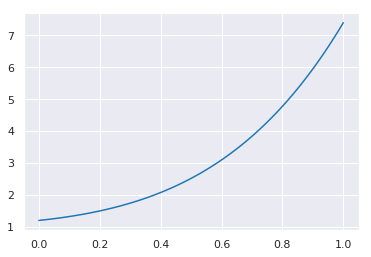

In [229]:
zvec = np.linspace(0.,1.,100)
# plt.scatter(zcls,nbkgt)
plt.plot(zvec,background_model(zvec))
#plt.xscale('log')
# plt.yscale('log')

In [230]:
sigma0 = 0.03

In [231]:
## cid, z_true, z, zerr, zoffset, pz0, true

ngals,nbkgt,nbkg = [],[],[]
table = []
for i in range(len(zcls)):
    ztrue, znoise, zerr, zoffset, pz0 = generate_galaxy_photoz_distribution(zcls[i],ngalst[i],zwindow=sigma0,delta_z=0.001)
    ti = generate_table([ztrue,znoise,zerr,zoffset,pz0],['z_true','z','zerr','zoffset','pz0'])
    
    #idx, = np.where( (zbkg-zcls[i])<=0.5*sigma*(1+zcls[i]) )
    
    zmin,zmax = zcls[i]-6.*sigma0*(1+zcls[i]),zcls[i]+6.*sigma0*(1+zcls[i])
    zp = np.arange(zmin,zmax+sigma0,sigma0)
    Nbkg = int(np.sum(background_model(zp)))
    #Nbkg= int( background_model(zcls[i])*(1+1.*np.log10(ngalst[i])) )
    
    zbkg_true, zbkg, zerr_bkg = generate_bkg(zmin,zmax,Nbkg)
    zoffset_bkg, pz0_bkg = compute_pz0(zbkg,zerr_bkg,zcls[i])
    t2 = generate_table([zbkg_true,zbkg,zerr_bkg,zoffset_bkg,pz0_bkg],['z_true','z','zerr','zoffset','pz0'])
    
    ti['True']= True
    t2['True']= False
    
    gi = vstack([ti,t2])
    gi['CID'] = i
    gi['redshift'] = zcls[i]
    
    nbkg_sigma = np.where(np.abs(zbkg_true-zcls[i])<=3.*sigma0*(1+zcls[i]))[0].size
    
    nbkgt.append(nbkg_sigma)
    ngals.append( np.sum(pz0) )
    nbkg.append(np.sum(pz0_bkg*1.))
    table.append(gi)
    
    ti=t2=0

In [232]:
gal = vstack(table)

### Count the background galaxies
we define as the true background, all the galaxies inside

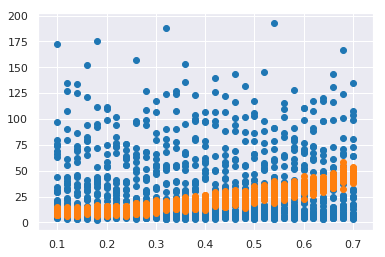

In [233]:
plt.scatter(zcls,ngalst)
plt.scatter(zcls,nbkgt)

(1.0, 64.98224765677858)

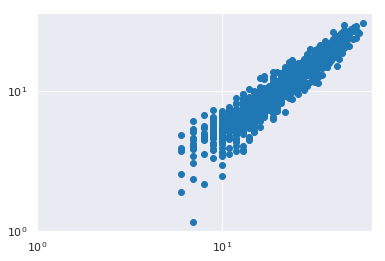

In [234]:
plt.scatter(nbkgt,nbkg)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1,)
plt.xlim(1.,)

(0.0, 2.0)

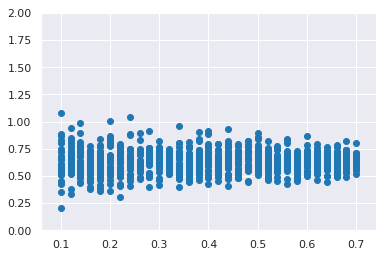

In [235]:
residual = 2*0.613*(np.array(nbkg))/(np.array(nbkgt))
plt.scatter(zcls,residual)
plt.ylim(0.,2.)

In [236]:
np.mean(residual)

0.6335612100678113

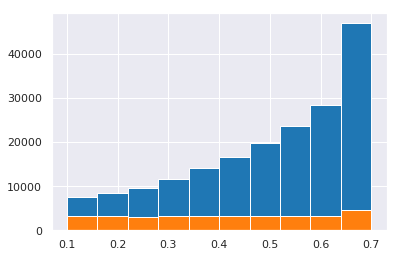

In [215]:
_ = plt.hist(gal['redshift'])
_ = plt.hist(gal['redshift'][gal['True']])

In [791]:
idx   = np.where(gal['CID']==200)[0]
gi   = gal[idx]
true = gi['True']
bkg  = np.logical_not(true)

Text(0.5,0,'zoffset')

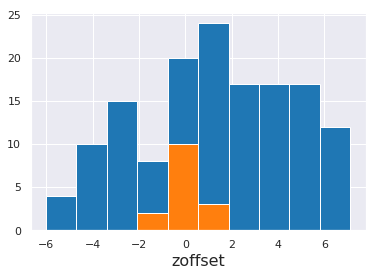

In [792]:
a = plt.hist(gi['zoffset']/0.03)
_ = plt.hist(gi['zoffset'][true]/0.03,bins=a[1])
#_ = plt.hist(gal['zoffset'][idx][bkg[idx]],bins=a[1])
plt.xlabel('zoffset',fontsize=16)

In [216]:
def generate_bkg(zmin,zmax,Nbkg):
    z_rnd = np.random.uniform(zmin,zmax,10000)
    
    probs = (1+z_rnd)**3
    probs = probs/np.sum(probs)

    ## Draw the NFW model distribution
    idx_rnd = np.arange(len(z_rnd))
    idx = np.random.choice(idx_rnd, size=Nbkg, p=probs)

    zbkg_true     = z_rnd[idx]
    zbkg,zerr_bkg = add_noise(zbkg_true,zwindow=sigma0)
    return zbkg_true, zbkg, zerr_bkg

def add_noise(ztrue,zwindow=0.03):
    zerr = zwindow*np.ones_like(ztrue)*(1+ztrue)
    
    znoise= ztrue+np.random.normal(scale=zwindow,size=ztrue.size)*(1+ztrue)
    znoise= np.where(znoise<0.,0.,znoise) # there is no negative redshift
    return znoise, zerr

def compute_pz0(znoise,zerr,zcls):
    zoffset = (znoise-zcls)/(1+zcls)
    pz0     = compute_pdfz(zoffset,zerr,zerr[0],zcls,correction=True)
    return zoffset, pz0

In [205]:
z_rnd = np.random.uniform(0.,1.5,100000)

probs = (1+z_rnd)**3
probs = probs/np.sum(probs)

## Draw the NFW model distribution
idx_rnd = np.arange(len(z_rnd))
idx = np.random.choice(idx_rnd, size=100000, p=probs)

zbkg_true     = z_rnd[idx]
zbkg,zerr_bkg = add_noise(zbkg_true,zwindow=sigma0)

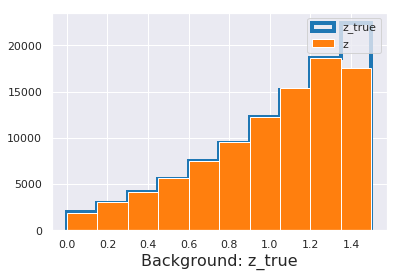

In [206]:
a = plt.hist(zbkg_true,histtype='step',lw=4,label='z_true')
_ = plt.hist(zbkg,bins=a[1],label='z')
plt.xlabel('Background: z_true',fontsize=16)
plt.legend()